# MultiUniMulitplication

A unit is a Strassen-Multiplication StepFunction.
Matrix multiplication to be performed is `m.dot(m.transpose)` with `m.dim(4000,4000)`.
M will be divided into `4*4=16` matrix partitions of dimension `1000*1000`. Partitions will be named m_row_col from m_0_0, m_0_1 ... to m_3_3.


m_0_0  |  m_0_1  |  m_0_2  |  m_0_3

m_1_0  |  m_1_1  |  m_1_2  |  m_1_3

m_2_0  |  m_2_1  |  m_2_2  |  m_2_3

m_3_0  |  m_3_1  |  m_3_2  |  m_3_3

## Content

1. Matrix Creation (matrix_dimension, block_sizes)
2. Matrix deployment (bucket, matrix_names)
3. Matrix multiplication (invoke matrix-multiplication-lambda)
4. check results in S3
5. create time profile for 3 stages (interm., collection, accumulation)
6. Compare Timings

matrix dimensions: 4000x4000, 8000x8000, 2000x16000   
block sizes: 1000x1000, 2000x2000, 3000x3000

## 0. Imports & Setup

In [2]:
from collections import namedtuple
from collections import defaultdict
from datetime import datetime
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
import os
import boto3
import json
import base64
import csv

In [20]:
# automatically reload the libraries from time_profiling.py
import sys
module_path = os.path.abspath(os.path.join('/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks'))
if module_path not in sys.path:
    sys.path.append(module_path)
from time_profiling import *
%load_ext autoreload
%autoreload 2

In [8]:
# NAMEDTUPLES
MatrixDimensions = namedtuple('MatrixDimensions', ['height', 'width'])
Timings = namedtuple('Timings', ['down','up','calculation'])

In [770]:
# global constants
BLOCK_SIZE = 1000
BUCKET = 'jmue-multiplication-benchmarks'
PREFIX = 'sq'
BENCHMARKS_FOLDER = '/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/'
SFN_PREFIX = 'log-test'

In [5]:
# CLIENTS
s3_client = boto3.client('s3')
lambda_client = boto3.client('lambda')
sfn_client = boto3.client('stepfunctions')

In [6]:
def _log(message):
    timestamp = datetime.now().strftime('%d.%m.%y %H:%M:%S > ')
#     LOG_FILE.write(timestamp + message)
    print timestamp + message

## 1. Matrix Creation

### Generate Matrix Blocks

In [142]:
def write_block_to_file(block, directory, row, column):
    if not os.path.exists(directory):
        os.mkdir(directory)
    path = os.path.join(directory, "m_" + str(row) + "_" + str(column))
    np.save(path, block)

### create random blocks

In [67]:
def get_block_with_random(height, width):
    return np.random.random_sample((height,width))

In [660]:
def create_blocks_with_random(x, y, block_height, block_width, matrix_name):
    for i in range(0,x):
        for j in range(0,y):
            block = get_block_with_random(block_height, block_width)
            directory = '/tmp/' + matrix_name
            write_block_to_file(block, directory, i, j)

In [150]:
create_blocks_with_random(matrix_dimensions.height/1000, matrix_dimensions.width/1000, block_size, block_size, matrix_name)

In [151]:
create_blocks_with_random(matrix_dimensions.height/1000, matrix_dimensions.width/1000, block_size, block_size, matrix_name=matrix_name + "-2")

### (OR create specific matrix and split it)

In [143]:
def split_matrix_into(matrix, x, y, block_size):
    '''split matrix into x*y partitions of given size'''
    p = block_size
    for i in range(0,x):
        for j in range(0,y):
            block = matrix[i*p:(i+1)*p, j*p:(j+1)*p]
            directory = "/tmp/" + matrix_name
            write_block_to_file(block, directory, i, j)

In [144]:
def create_square_staircase_matrix(matrix_dimensions):
    matrix = np.zeros(matrix_dimensions, dtype=np.int)
    for i in range(matrix_dimensions.height):
        for j in range(matrix_dimensions.width):
            matrix[i][j] = i+j
    return np.array(matrix)

In [261]:
sq_m = create_square_staircase_matrix(matrix_dimensions)
sq_m = np.transpose(create_square_staircase_matrix(width=4000))
split_matrix_into(sq_m, 4, 4, 1000)

## 2. Matrix Deployment

In [773]:
def upload_blocks(matrix_name, bucket, s3_matrix_name=None):
    localpath = '/tmp/' + matrix_name
    filenames = os.listdir(localpath)

    s3_folder = matrix_name
    if s3_matrix_name is not None:
        s3_folder = s3_matrix_name
    
    for filename in filenames:
        _log('Uploading to s3: {}'.format(filename))
        s3_client.upload_file(
            Filename=os.path.join(localpath,filename),
            Bucket=bucket,
            Key=os.path.join(s3_folder,filename)
        )

In [774]:
def deploy_matrices(matrix_name):
    _log('Uploading matrix to s3: {}'.format(matrix_name))
    upload_blocks(matrix_name, BUCKET)
    _log('Uploading matrix to s3: {}'.format(matrix_name + '-2'))
    upload_blocks(matrix_name, BUCKET, s3_matrix_name=matrix_name + '-2')

In [829]:
def deployed(matrix_names, bucket, matrix_dimensions, block_size):
    for matrix_name in matrix_names:
        key_count = s3_client.list_objects_v2(Bucket=bucket, Prefix=matrix_name+'/')['KeyCount']
        print key_count
        if key_count != (matrix_dimensions.height/block_size * matrix_dimensions.width/block_size):
            return False # this one is not deployed yet
    return True

In [830]:
deployed(['sq_2kx2k','sq_2kx2k-2'], 'jmue-multiplication-benchmarks', MatrixDimensions(2000,2000), 1000)

4
4


True

In [827]:
res = s3_client.list_objects_v2(Bucket=bucket, Prefix=matrix_name)

In [828]:
res

{u'Contents': [{u'ETag': '"bf4cba65588650a093d9df20b38cce21"',
   u'Key': 'square_matrix_2kx2k-2/m_0_0.npy',
   u'LastModified': datetime.datetime(2017, 8, 29, 12, 56, 56, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'},
  {u'ETag': '"c1f83bfb89a88af7adfe082c43678be5"',
   u'Key': 'square_matrix_2kx2k-2/m_0_1.npy',
   u'LastModified': datetime.datetime(2017, 8, 29, 12, 56, 56, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'},
  {u'ETag': '"3e98bc61457e257d7bac68664c6f80e1"',
   u'Key': 'square_matrix_2kx2k-2/m_1_0.npy',
   u'LastModified': datetime.datetime(2017, 8, 29, 12, 56, 58, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'},
  {u'ETag': '"31dbb129525cb034be7e737a81dc2b36"',
   u'Key': 'square_matrix_2kx2k-2/m_1_1.npy',
   u'LastModified': datetime.datetime(2017, 8, 29, 12, 56, 59, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'},
  {u'ETag': '"a492200a88924052bb19464b90437fb7"',
   u'Key': 'squar

In [154]:
upload_blocks(matrix_name, bucket)
upload_blocks(matrix_name, bucket, matrix_name + "-2")

## 3. Matrix Multiplication

### Create Input

In [775]:
def create_input(state_machine_name, executionName, name_matrixA, name_matrixB):
    input = {
            'state-machine-name': state_machine_name,
            'executionName': executionName,
            'matA': {
            'bucket': BUCKET,
            'folder': name_matrixA,
            'rows': matrix_dimensions.height,
            'columns': matrix_dimensions.width
            },
            'matB': {
              'bucket': BUCKET,
              'folder': name_matrixB,
              'rows': matrix_dimensions.height,
              'columns': matrix_dimensions.height
            },
            'result': {
              'bucket': BUCKET,
              'folder': matrix_name + '-result'
            },
            'split-size': BLOCK_SIZE * 2
        }
    return input

In [776]:
create_input(
        state_machine_name="multi-unit-mmultiply-2kx2k",
        executionName="2kx2k-online-profiled-3",
        name_matrixA=matrix_name,
        name_matrixB=matrix_name + "-2"
)

{'executionName': '2kx2k-online-profiled-3',
 'matA': {'bucket': 'jmue-multiplication-benchmarks',
  'columns': 2000,
  'folder': 'square_matrix_2kx2k',
  'rows': 2000},
 'matB': {'bucket': 'jmue-multiplication-benchmarks',
  'columns': 2000,
  'folder': 'square_matrix_2kx2k-2',
  'rows': 2000},
 'result': {'bucket': 'jmue-multiplication-benchmarks',
  'folder': 'square_matrix_2kx2k-result'},
 'split-size': 2000,
 'state-machine-name': 'multi-unit-mmultiply-2kx2k'}

### Invoke Matrix Multiplication Lambda

In [777]:
def invoke_matrix_multiplication(state_machine_name, executionName, name_matrixA, name_matrixB):
    """ execution_info.keys() :> ['deploy-nr', 'split-executions', 'split'] """
    sfn_input = create_input(state_machine_name, executionName, name_matrixA, name_matrixB)
    _log("Invoking matrix multiplication with input: {}".format(sfn_input))
    response = lambda_client.invoke(
        FunctionName='mmultiply-prod-multi-unit-multiplication',
        InvocationType='RequestResponse',
        LogType='Tail',
        Payload=json.dumps(sfn_input)
    )
    _log('LogResult: \n{}'.format(base64.b64decode(response['LogResult'])))
    return json.loads(response['Payload'].read())

In [301]:
invoke_matrix_multiplication(
        state_machine_name="multi-unit-mmultiply-2kx2k",
        executionName="2kx2k-online-profiled-3",
        name_matrixA=matrix_name,
        name_matrixB=matrix_name + "-2"
)

START RequestId: 537fc94a-966b-11e7-af2b-47d16c6cff42 Version: $LATEST
Split_0 (x:0 y:0) 
END RequestId: 537fc94a-966b-11e7-af2b-47d16c6cff42
REPORT RequestId: 537fc94a-966b-11e7-af2b-47d16c6cff42	Duration: 305.35 ms	Billed Duration: 400 ms 	Memory Size: 1024 MB	Max Memory Used: 37 MB	



In [778]:
payload

{u'deploy-nr': u'MUM101',
 u'split-executions': [{u'executionARN': u'arn:aws:states:eu-central-1:146904559692:execution:multi-unit-mmultiply-2kx2k:2kx2k-online-profiled-3-split0',
   u'split': 0}],
 u'state-machine-arn': u'arn:aws:states:eu-central-1:146904559692:stateMachine:multi-unit-mmultiply-2kx2k'}

## 5. Check Results

In [779]:
def executions_pending(executionARNs):
    """ Checks if all executions have either succeeded or failed yet.
    Failed executions are skipped. """
    for executionARN in executionARNs:
        last_event = sfn_client.get_execution_history(
            executionArn=executionARN,
            maxResults=1,
            reverseOrder=True
        )['events'][0]

        if last_event['type'] == 'ExecutionFailed':
            _log('Execution {} failed.'.format(executionARN))
            pass
        elif last_event['type'] != 'ExecutionSucceeded':
            return True # Executions still pending
    _log('All executions finished(failed/succeeded).')
    return False

In [303]:
executionARN = payload['split-executions'][0]['executionARN']

In [784]:
example_last_events = {'ResponseMetadata': {'HTTPHeaders': {'content-length': '688',
   'content-type': 'application/x-amz-json-1.0',
   'x-amzn-requestid': 'e5d0e4ed-9672-11e7-be52-1dc3610e5038'},
  'HTTPStatusCode': 200,
  'RequestId': 'e5d0e4ed-9672-11e7-be52-1dc3610e5038',
  'RetryAttempts': 0},
 u'events': [{u'executionSucceededEventDetails': {u'output': u'{"deploy-nr": "ACC101", "time-profile": {"s3-up": 272, "execution": 463, "s3-down": 181, "lambda": "accumulate"}}'},
   u'id': 71,
   u'previousEventId': 70,
   u'timestamp': 'datetime.datetime(2017, 9, 10, 23, 2, 30, 289000, tzinfo=tzlocal())',
   u'type': u'ExecutionSucceeded'}],
 u'nextToken': u'AAAAKgAAAAIAAAAAAAAAAXEKCno//DEFaC8MQTHN8/j/sMIb5TAXYFZcn3Yx5Alzsu/jg5+6tKdcIuKW2vig+OECYiBGedLHpb51hZfpvxTUoiZAFC6lAqKJUULDu5LR7bQ8mN+5uUKzk3xqSb6EZJzfdv4ve+IJBIkrJ7c8N3GYjGjFKUpqEPiBWReh9RxzdAO3RWpWJpcOpzPLdceEvaPKKpkj7mP93r+w4txVvc+nTX9az0dMBgRGxmiarOuobnPKNj9sWNHZvueyMZcRsj1K19aBB/99Q/5sLEbQaqSdCdZzuRJJiOgE9bhG2hgCgiNzuAp8jzzfeKT5ZdtlGg=='}

In [780]:
last_events

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '688',
   'content-type': 'application/x-amz-json-1.0',
   'x-amzn-requestid': 'e5d0e4ed-9672-11e7-be52-1dc3610e5038'},
  'HTTPStatusCode': 200,
  'RequestId': 'e5d0e4ed-9672-11e7-be52-1dc3610e5038',
  'RetryAttempts': 0},
 u'events': [{u'executionSucceededEventDetails': {u'output': u'{"deploy-nr": "ACC101", "time-profile": {"s3-up": 272, "execution": 463, "s3-down": 181, "lambda": "accumulate"}}'},
   u'id': 71,
   u'previousEventId': 70,
   u'timestamp': datetime.datetime(2017, 9, 10, 23, 2, 30, 289000, tzinfo=tzlocal()),
   u'type': u'ExecutionSucceeded'}],
 u'nextToken': u'AAAAKgAAAAIAAAAAAAAAAXEKCno//DEFaC8MQTHN8/j/sMIb5TAXYFZcn3Yx5Alzsu/jg5+6tKdcIuKW2vig+OECYiBGedLHpb51hZfpvxTUoiZAFC6lAqKJUULDu5LR7bQ8mN+5uUKzk3xqSb6EZJzfdv4ve+IJBIkrJ7c8N3GYjGjFKUpqEPiBWReh9RxzdAO3RWpWJpcOpzPLdceEvaPKKpkj7mP93r+w4txVvc+nTX9az0dMBgRGxmiarOuobnPKNj9sWNHZvueyMZcRsj1K19aBB/99Q/5sLEbQaqSdCdZzuRJJiOgE9bhG2hgCgiNzuAp8jzzfeKT5ZdtlGg=='}

## 6. Create Timing Profiles

### Get all Timings

In [785]:
def extract_time_profiles(events):
    """ Time profiles are part of the lambda output which is returned as a json formated string """
    _log("Extracting time profiles")
    lambda_outputs = [x['lambdaFunctionSucceededEventDetails']['output'] for x in events if x['type'] == 'LambdaFunctionSucceeded']
    time_profiles = [json.loads(x)['time-profile'] for x in lambda_outputs]

    time_profiles_by_lambda = defaultdict(list)
    for profile in time_profiles:
        time_profiles_by_lambda[profile['lambda']].append(profile)

    return time_profiles_by_lambda

In [786]:
def get_all_events(executionARNs):
    events = []
    for executionARN in executionARNs:
        _log('Retrieving execution history for {}'.format(executionARN))
        response = sfn_client.get_execution_history(executionArn=executionARN)
        events.extend(response['events'])

        while response.has_key('nextToken'):
            _log('Loading further events')
            response = sfn_client.get_execution_history(
                executionArn=executionARN,
                nextToken=response['nextToken']
            )
            events.extend(response['events'])

    return events

In [795]:
def parse_time_profiles(executionARNs):
    events = get_all_events(executionARNs)
    time_profiles_by_lambda = extract_time_profiles(events)
    return time_profiles_by_lambda

In [794]:
example_time_profiles_by_lambda ={
             u'accumulate': [{u'execution': 463,
               u'lambda': u'accumulate',
               u's3-down': 181,
               u's3-up': 272}],
             u'collect': [{u'execution': 2978,
               u'lambda': u'collect',
               u's3-down': 1741,
               u's3-up': 1166}],
             u'intermediate': [{u'execution': 2303,
               u'lambda': u'intermediate',
               u's3-down': 923,
               u's3-up': 189},
              {u'execution': 2693,
               u'lambda': u'intermediate',
               u's3-down': 980,
               u's3-up': 518},
              {u'execution': 2152,
               u'lambda': u'intermediate',
               u's3-down': 735,
               u's3-up': 247},
              {u'execution': 2295,
               u'lambda': u'intermediate',
               u's3-down': 902,
               u's3-up': 261},
              {u'execution': 2288,
               u'lambda': u'intermediate',
               u's3-down': 868,
               u's3-up': 242},
              {u'execution': 2489,
               u'lambda': u'intermediate',
               u's3-down': 993,
               u's3-up': 347},
              {u'execution': 2416,
               u'lambda': u'intermediate',
               u's3-down': 1000,
               u's3-up': 299}]}

## Plot Results

In [13]:
def plot_timing_profile(timings, lambda_type, state_machine_name, plot_folder, save_to_file=True):
    # e.g. './block_size_1000/sq_2kx2k_intermediate.png'
    plot_path = '{}/{}_{}.png'.format(folder, state_machine_name, lambda_type)
    _log('Creating plot {}'.format(plot_path))
    
    N = len(timings.down)
    index = np.arange(N)    # the x locations for the groups
    width = 0.5           # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    p1 = plt.bar(index, timings.down, width, color='b')
    p2 = plt.bar(index, timings.up, width, color='c', bottom=timings.down)
    p3 = plt.bar(index, timings.calculation, width, color='m', bottom=np.add(timings.down,timings.up))

    # ax.set_ybound() # take the max value of execution plus 100
    # ax.set_xbound() # number of intermediate lambdas?

    ax.set_ylabel('time in ms')
    ax.set_xlabel('execution index, 0 is averages across executions')
    ax.set_title('Timing profiles for {}-lambda executions.'.format(lambda_type))
    ax.legend((p3, p2, p1), ('Calculation', 'S3 upload','S3 download'), loc=4)

    if (save_to_file):
        plt.savefig(os.path.join(BENCHMARKS_FOLDER, plot_path), dpi=500)
    else:
        plt.show()

In [798]:
def collect_values(time_profiles_by_lambda, add_average=True):
    """collect values into arrays and return them as a timings tuple"""
    s3_down ,s3_up ,calcs = [], [] ,[]
    for item in time_profiles_by_lambda:
        s3_down.append(item['s3-down'])
        s3_up.append(item['s3-up'])
        calcs.append(item['execution']-item['s3-down']-item['s3-up'])
    
    if add_average:
        # add the average as the first value
        s3_down = np.append(np.average(s3_down), s3_down)
        s3_up = np.append(np.average(s3_up), s3_up)
        calcs = np.append(np.average(calcs), calcs)
      
    return Timings(s3_down, s3_up, calcs)

In [799]:
def plot_time_profiles(time_profiles_by_lambda, state_machine_name, folder):
    _log("Plotting time profiles for {}".format(state_machine_name))

    for lambda_type in time_profiles_by_lambda.keys():
        timings = collect_values(time_profiles_by_lambda[lambda_type], add_average=True)
        plot_timing_profile(timings, lambda_type, state_machine_name, folder)

### Intermediate Timings

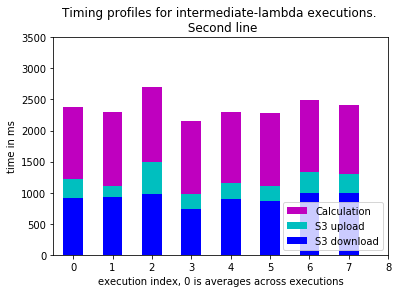

In [707]:
lambda_type = 'intermediate'
intermediate_timings = collect_values(time_profiles_by_lambda[lambda_type], add_average=True)
plot_timing_profile(intermediate_timings, lambda_type)

### Collector Timings

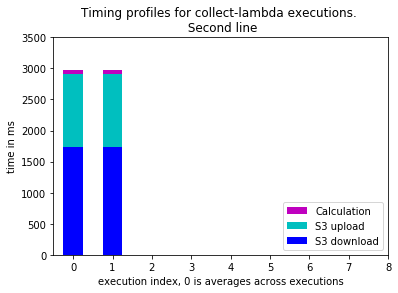

In [676]:
lambda_type = 'collect'
collect_timings = collect_values(time_profiles_by_lambda[lambda_type], add_average=True)
plot_timing_profile(collect_timings, lambda_type)

### Accumulator Timings

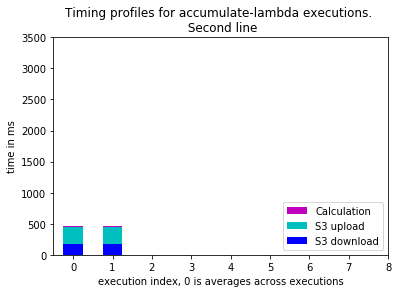

In [674]:
lambda_type = 'accumulate'
plot_timing_profile(timings, 'all lambda')

### Combined Timings from file

In [36]:
# Load timings from csv
folder = '/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/v2_benchmark_bs2/block_size_2000/'
filename = 'v2_benchmark_bs2-4kx4k.csv'

path = os.path.join(folder, filename)

with open(path, 'r') as f:
    reader = csv.DictReader(f, delimiter=',')
    # 'type','down','up','execution'
    up, down, calculation = [], [], []
    for row in reader:
        up.append(row['up']) 
        down.append(row['down'])
        calculation.append(int(row['execution']) - int(row['down']) - int(row['up']))
combined_timings = Timings(np.array(up, dtype=int), np.array(down, dtype=int), np.array(calculcation, dtype=int))

In [37]:
combined_timings

Timings(down=array([4587, 5021,  976, 1446, 1085, 1310, 1243, 1382, 2081]), up=array([2002, 7614, 2085, 2818, 3441, 3414, 3775, 3583, 3250]), calculation=array([ 132,  385, 9362, 9247, 8897, 9248, 9383, 9444, 9268]))

22.09.17 13:51:08 > Creating plot /Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/v2_benchmark_bs2/block_size_2000//v2_benchmark_bs2-8kx8k_combined.png


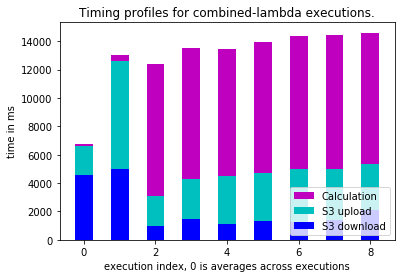

In [38]:
plot_timing_profile(combined_timings, "combined", "v2_benchmark_bs2-8kx8k", "plot-folder", save_to_file=False)

In [76]:
def plot_time_distribution(up, down, calculation):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'up', 'down', 'calculation'
    sizes = [up, down, calculation]
    explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

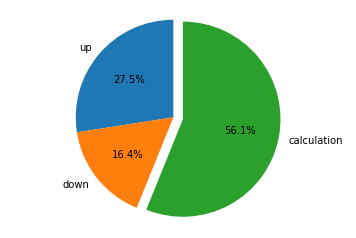

In [77]:
plot_time_distribution(np.sum(combined_timings.up), np.sum(combined_timings.down), np.sum(combined_timings.calculation))

In [101]:
data = np.array([1,2,3])
s3_client.put_object(Body=data.dumps(), Bucket='jmue-matrix-tests', Key='put-object')

{u'ETag': '"c2fd187af5f8937bf52ad74880ae3e09"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Fri, 22 Sep 2017 15:22:14 GMT',
   'etag': '"c2fd187af5f8937bf52ad74880ae3e09"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'xC1KupFOijlB/Br/2Z5GF36R/ftfxvlUWxkU4KGIYP3822fmn/ia8es7D5hC2T1rQkd4/0hUycs=',
   'x-amz-request-id': '49593830053D54FF'},
  'HTTPStatusCode': 200,
  'HostId': 'xC1KupFOijlB/Br/2Z5GF36R/ftfxvlUWxkU4KGIYP3822fmn/ia8es7D5hC2T1rQkd4/0hUycs=',
  'RequestId': '49593830053D54FF',
  'RetryAttempts': 0}}

In [88]:
def download_s3_file(bucket, folder, filename, s3_client):
    if not os.path.exists('/tmp/' + folder):
        os.mkdir('/tmp/' + folder)

    key = folder + "/" + filename # e.g. 'S3_U0_m2'
    s3_client.download_file(bucket, key, '/tmp/' + key)
    return '/tmp/' + key

In [102]:
s3_client.download_file('jmue-matrix-tests', 'put-object', '/tmp/put-object')
np.load('/tmp/put-object')

array([1, 2, 3])

## Save raw data to file

In [801]:
def save_raw_data(time_profiles_by_lambda, csv_path):
    _log("Writing time profiles to file: {}".format(csv_path))
    with open(csv_path, 'wb') as file:
        writer =  csv.writer(file, delimiter=',')
        writer.writerow(['type','down','up','execution'])
        for lambda_type in time_profiles_by_lambda.keys():
            timings = time_profiles_by_lambda[lambda_type]
            for t in timings:
                writer.writerow([lambda_type, t['s3-down'], t['s3-up'], t['execution']])

In [1]:
time_profiles_by_lambda

NameError: name 'time_profiles_by_lambda' is not defined

## Print Metadata

number of elements, number of intermediate-, collect-, accumulate-lambdas ...

## EXECUTE BENCHMARK

In [ ]:
########################
### GLOBAL CONSTANTS ###
########################

BLOCK_SIZE = 1000
BUCKET = 'jmue-multiplication-benchmarks'
PREFIX = 'sq'
BENCHMARKS_FOLDER = '/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/'
SFN_PREFIX = 'log-test'

########################
###   Main Programm  ###
########################

# folder where all the plots, csv, and log files are written
folder = os.path.join(BENCHMARKS_FOLDER,'block_size_{}'.format(BLOCK_SIZE), SFN_PREFIX)
if not os.path.exists(folder):
    os.mkdir(folder)
LOG_FILE = open(os.path.join(folder, SFN_PREFIX + '.log'), 'a')

_log('benchmark parameters:\n  BLOCK_SIZE:{}\n  BUCKET:{}\n  PREFIX:{}\n  BENCHMARKS_FOLDER:{}\n  SFN_PREFIX:{}'.format(
                                BLOCK_SIZE, BUCKET, PREFIX, BENCHMARKS_FOLDER, SFN_PREFIX))

matrix_dimension_sets = [
        MatrixDimensions(height=2000, width=2000),
        # MatrixDimensions(height=3000, width=3000),
        # MatrixDimensions(height=4000, width=4000)
        # MatrixDimensions(height=5000, width=5000)
]

_log(str(matrix_dimension_sets))

for matrix_dimensions in matrix_dimension_sets:
    matrix_name = '{}_{}kx{}k'.format(PREFIX, matrix_dimensions.height/1000, matrix_dimensions.width/1000)
    _log('Benchmarking {}'.format(matrix_name))

    # create_matrices(matrix_dimensions, matrix_name)
    # deploy_matrices(matrix_name)

    state_machine_name = '{}-{}kx{}k'.format(SFN_PREFIX, matrix_dimensions.height/1000, matrix_dimensions.width/1000)
    execution_info = invoke_matrix_multiplication(
            state_machine_name=state_machine_name,
            executionName=state_machine_name,
            name_matrixA=matrix_name,
            name_matrixB=matrix_name + '-2'
    )
    split_executionARNs = [x['executionARN'] for x in execution_info['split-executions']]
    _log("Waiting for pending executions to finish...")
    while executions_pending(split_executionARNs):
        sleep(2)

    time_profiles_by_lambda = parse_time_profiles(split_executionARNs)
    save_raw_data(time_profiles_by_lambda, csv_path=os.path.join(folder, state_machine_name + '.csv'))
    plot_time_profiles(time_profiles_by_lambda, state_machine_name, folder)

# compare_time_profiles()

LOG_FILE.close()


## 7. Compare Timings

### Baseline Lambda

In [111]:
import matplotlib.pyplot as plt

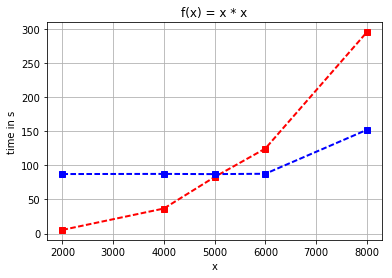

In [139]:
%matplotlib inline
x = [2000, 4000, 5000, 6000, 8000]
y = [5.293, 36.736, 83.031, 124.862, 295.771]
mem = [ 87.4, 87.6 ,87.3 ,87.8,152.3]

fig, ax = plt.subplots()
ax.plot(x, y, color='red', linestyle='--', linewidth=2, marker='s')
ax.plot(x, mem, color='blue', linestyle='--', linewidth=2, marker='s')
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('time in s')
ax.set_title('f(x) = x * x')

### Input Format

In [ ]:
{
  "matA": {
    "bucket": "jmue-matrix-tests",
    "key": "sc4000",
    "split": { ... }
  },
  "matB": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000t",
      "split": { ... }
  },
  "result": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000-result"
  }
}

{
  "matA": {
    "bucket": "jmue-matrix-tests",
    "key": "sc4000",
    "split": {
      "x1": 0,
      "y1": 0,
      "x2":1000,
      "y2":1000
    }
  },
  "matB": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000t",
      "split": {
        "x1": 0,
        "y1": 0,
        "x2":1000,
        "y2":1000
      }
  },
  "result": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000-result"
  }
}

# A split
{
  "split": {
    "x1": 0,
    "y1": 0,
    "x2":1000,
    "y2":1000
  }
}

In [175]:
matrix = { "bucket": "jmue-matrix-tests", "key": "sc4000", "split": { "x1": 0, "y1": 0, "x2":1000, "y2":1000 } }
x1 = matrix['split']['x1']
y1 = matrix['split']['y1']
key = matrix['key'] +  "/m_" + str(x1) + "_" + str(y1) + ".npy"
print key

sc4000/m_0_0.npy


In [184]:
if not False:
    print "False"

False


In [185]:
if not os.path.exists('/tmp/' + matrix['key']):
    os.mkdir('/tmp/' + matrix['key'])
s3_client.download_file('jmue-matrix-tests', key, '/tmp/' + key)
split = np.load('/tmp/' + key)

In [174]:
split

array([[   0,    1,    2, ...,  997,  998,  999],
       [   1,    2,    3, ...,  998,  999, 1000],
       [   2,    3,    4, ...,  999, 1000, 1001],
       ..., 
       [ 997,  998,  999, ..., 1994, 1995, 1996],
       [ 998,  999, 1000, ..., 1995, 1996, 1997],
       [ 999, 1000, 1001, ..., 1996, 1997, 1998]])

In [5]:
import json
import math

In [83]:
b = 5
a = {"key": b, "key2": "Hello"}
sfn_input = json.dumps({"value": a["key"]})

In [84]:
sfn_input

'{"value": 5}'

In [98]:
int(math.ceil(4030.0/2000.0))

3

In [150]:
ssl = 1000
def call_multi(i,j,k):
    print "x1", str(i*ssl), "y1", str(k*ssl), "| x1", str(k*ssl), "y1", str(j*ssl)
    print "x2", str((i+1)*ssl), "y2", str((k+1)*ssl), "| x2", str((k+1)*ssl), "y2", str((j+1)*ssl)

In [151]:
m = 3
n = 2
p = 2

for i in range(m):
    for j in range(n):
        for k in range(p):
            print "A" + str(i+1) + str(k+1) + "*" + "B" + str(k+1) + str(j+1)
            call_multi(i,j,k)
        print ""

A11*B11
x1 0 y1 0 | x1 0 y1 0
x2 1000 y2 1000 | x2 1000 y2 1000
A12*B21
x1 0 y1 1000 | x1 1000 y1 0
x2 1000 y2 2000 | x2 2000 y2 1000

A11*B12
x1 0 y1 0 | x1 0 y1 1000
x2 1000 y2 1000 | x2 1000 y2 2000
A12*B22
x1 0 y1 1000 | x1 1000 y1 1000
x2 1000 y2 2000 | x2 2000 y2 2000

A21*B11
x1 1000 y1 0 | x1 0 y1 0
x2 2000 y2 1000 | x2 1000 y2 1000
A22*B21
x1 1000 y1 1000 | x1 1000 y1 0
x2 2000 y2 2000 | x2 2000 y2 1000

A21*B12
x1 1000 y1 0 | x1 0 y1 1000
x2 2000 y2 1000 | x2 1000 y2 2000
A22*B22
x1 1000 y1 1000 | x1 1000 y1 1000
x2 2000 y2 2000 | x2 2000 y2 2000

A31*B11
x1 2000 y1 0 | x1 0 y1 0
x2 3000 y2 1000 | x2 1000 y2 1000
A32*B21
x1 2000 y1 1000 | x1 1000 y1 0
x2 3000 y2 2000 | x2 2000 y2 1000

A31*B12
x1 2000 y1 0 | x1 0 y1 1000
x2 3000 y2 1000 | x2 1000 y2 2000
A32*B22
x1 2000 y1 1000 | x1 1000 y1 1000
x2 3000 y2 2000 | x2 2000 y2 2000



In [242]:
def partition(matrix, x, y):
    split = matrix['split']
    x += split['x1']/1000
    y += split['y1']/1000
    partition_factor = ((split['x2']-split['x1'])/2)/1000 # length of split us twice the size of a partition

    filename = "m_" + str(partition_factor*x) + "_" + str(partition_factor*y) + ".npy"
    key = matrix['folder'] + "/" + filename # e.g. m_0_0.npy

    if not os.path.exists('/tmp/' + matrix['folder']):
        os.mkdir('/tmp/' + matrix['folder'])

    print key
    s3_client.download_file(matrix['bucket'], key, '/tmp/' + key)
    return np.load('/tmp/' + key)

In [241]:
s3_client.download_file("jmue-matrix-tests", "sc4000/m_3_2.npy", '/tmp/sc4000/m_3_2.npy')

In [244]:
matrix = { "bucket": "jmue-matrix-tests", "folder": "sc4000", "split": { "x1": 2000, "y1": 2000, "x2":4000, "y2":4000 } }
partition(matrix=matrix, x=1, y=0)

sc4000/m_3_2.npy


array([[5000, 5001, 5002, ..., 5997, 5998, 5999],
       [5001, 5002, 5003, ..., 5998, 5999, 6000],
       [5002, 5003, 5004, ..., 5999, 6000, 6001],
       ..., 
       [5997, 5998, 5999, ..., 6994, 6995, 6996],
       [5998, 5999, 6000, ..., 6995, 6996, 6997],
       [5999, 6000, 6001, ..., 6996, 6997, 6998]])

## Building a State Machine in Code

In [78]:
def task_state(resource, next_state=None):
    task_state = {
            "Type": "Task",
            "Resource": resource,
            "End": True
    }
    if next_state is not None:
        task_state["End"] = False
        task_state["Next"] = next_state
    return task_state

In [79]:
def pass_state(next_state, result=None, resultPath=None, outputPath=None):
    return {
              "Type": "Pass",
              "Result": result,
              "ResultPath": resultPath,
              "OutputPath": outputPath,
              "Next": next_state
    }

In [114]:
def parallel_state(branches, next_state, resultPath=None, outputPath=None):
    parallel_state = {
            "Type": "Parallel",
            "Next": next_state,
            "Branches": branches
    }
    if resultPath is not None:
        parallel_state["ResultPath"] = resultPath
    
    if outputPath is not None:
        parallel_state["OutputPath"] = outputPath
    
    return parallel_state

In [81]:
def branch(startAt, states):
    return {
        "StartAt": startAt,
        "States": states
    }

In [118]:
def create_strassen_sfn(unit=""):
    branches = []
    for index in range(0,7):
        unit_m = "U{}_m{}".format(unit, index) # U0_m_0
        unit_m_lambda = "U{}_m{}_lambda".format(unit, index) # U0_m_0_lambda
        states = {
            unit_m: pass_state(next_state=unit_m_lambda, result=index, resultPath="$.intermediate", outputPath="$"),
            unit_m_lambda: task_state(resource="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-strassen-split-intermediate")
        }
        branches.append(branch(states=states, startAt=unit_m))

    unit_name = "unit" + unit
    i_name = "U{}_Intermediate".format(unit)
    c_name = "U{}_Collect".format(unit)
    
    unit_setup = pass_state(next_state=i_name, result=unit, resultPath="$.unit", outputPath="$")
    intermediates = parallel_state(branches=branches, next_state=c_name, resultPath="$.responses", outputPath="$")
    collect = task_state(resource="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-strassen-split-collector")
        
    states = { unit_name: unit_setup, i_name: intermediates, c_name: collect }
    return branch(startAt=unit_name, states=states)

In [122]:
accumulation_arn="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-unit-accumulator"
unit_branches = []
for i in range(0,2):
    unit_branches.append(create_strassen_sfn(unit=str(i)))

split_states = {
    "Accumulate": task_state(resource=accumulation_arn),
    "Units": parallel_state(branches=unit_branches, next_state="Accumulate", resultPath="$.responses", outputPath="$")
}
partial = branch(startAt="Units", states=split_states)

In [123]:
with open('/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/state-machines/created.asl', 'w') as file:
    json.dump(partial, file)

In [124]:
result = { "folder": "sc4000-result"}
split = 3
block_index = "00"
response = s3_client.list_objects_v2(
      Bucket="jmue-matrix-tests",
      Prefix="{}/S{}_X{}".format(result['folder'], split, block_index)
    )

In [125]:
response

{u'Contents': [{u'ETag': '"675ba5b88cb01f66bd6b56d15646cc5e"',
   u'Key': 'sc4000-result/S3_X00_U0',
   u'LastModified': datetime.datetime(2017, 8, 4, 15, 59, 30, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'},
  {u'ETag': '"675ba5b88cb01f66bd6b56d15646cc5e"',
   u'Key': 'sc4000-result/S3_X00_U1',
   u'LastModified': datetime.datetime(2017, 8, 4, 15, 59, 25, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'}],
 u'IsTruncated': False,
 u'KeyCount': 2,
 u'MaxKeys': 1000,
 u'Name': 'jmue-matrix-tests',
 u'Prefix': 'sc4000-result/S3_X00',
 'ResponseMetadata': {'HTTPHeaders': {'content-type': 'application/xml',
   'date': 'Fri, 04 Aug 2017 16:19:37 GMT',
   'server': 'AmazonS3',
   'transfer-encoding': 'chunked',
   'x-amz-bucket-region': 'eu-central-1',
   'x-amz-id-2': 'e5IR4vIgZJX00HgHbBgBixJWhyqTlnZEKdV+bQatEGkGUysJGlAbJeewKRGgS4YVQvJ5IJth4g0=',
   'x-amz-request-id': '11F1494C37A87A8E'},
  'HTTPStatusCode': 200,
  'HostId': 'e5IR4vIgZJX00HgHbBg

### Padded matrix multiplication has the same result

In [5]:
import numpy as np
j = np.array([[x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)]])
j_padded = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
i = j.transpose()
i_padded = j_padded.transpose()
np.array_equal(i_padded.dot(j_padded), i.dot(j))

True